# Time Series Analysis and Stationarity

In [35]:
import warnings
warnings.filterwarnings('ignore')

In [36]:
%matplotlib inline

import pandas_datareader.data as web
import numpy as np
import pandas as pd
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
sns.set_style('whitegrid')

In [38]:
def plot_correlogram(
    x, 
    lags=None, 
    title=None,
    acf_ylim=None, 
    pacf_ylim=None,
    acf_xlim=None, 
    pacf_xlim=None
):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

    # Residual plot
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)

    # QQ plot
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1,2,3,4])
    s = (f"Mean: {mean:>12.2f}\n"
         f"SD: {np.sqrt(var):>16.2f}\n"
         f"Skew: {skew:12.2f}\n"
         f"Kurtosis:{kurtosis:9.2f}")
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)

    # ACF
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    if acf_ylim is not None:
        axes[1][0].set_ylim(acf_ylim)
    if acf_xlim is not None:
        axes[1][0].set_xlim(acf_xlim)

    # PACF
    plot_pacf(x=x, lags=lags, zero=False, ax=axes[1][1])
    if pacf_ylim is not None:
        axes[1][1].set_ylim(pacf_ylim)
    if pacf_xlim is not None:
        axes[1][1].set_xlim(pacf_xlim)

    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

## Download Series

Load minute crypto data

In [39]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection
from sklearn.manifold import MDS
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities, modularity


input_dir = 'data/'

In [40]:
symbols = ['BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'DOGEUSDT']

In [41]:
candlestick_cols = [
    "Open time",
    "Open",
    "High",
    "Low",
    "Close",
    "Volume",
    "Close time",
    "Quote asset volume",
    "Number of trades",
    "Taker buy base asset volume",
    "Taker buy quote asset volume",
    "Ignore"
]

In [42]:
def get_sorted_cols(cols):
    # Convert names → indices
    pairs = [(name, candlestick_cols.index(name)) for name in cols]

    # Sort by the index
    pairs_sorted = sorted(pairs, key=lambda x: x[1])

    # Extract sorted names and indices
    sorted_names  = [name for name, idx in pairs_sorted]
    sorted_indices = [idx for name, idx in pairs_sorted]

    return sorted_names, sorted_indices

In [43]:
def load_series(symbol, cols):
    time_serieses = []

    sorted_names, sorted_indices = get_sorted_cols(cols)
    col_names = [f'{symbol}_{name}' for name in sorted_names]
    df = pd.read_csv(
            os.path.join(input_dir, f"{symbol}.csv"),
            usecols=[0, *sorted_indices],
            header = None,
            names=["time", *col_names]
        )
    df.loc[df["time"] >= 1e15, "time"] = df["time"] // 1000
    df["time"] = pd.to_datetime(df["time"], unit="ms")
    df = df[df["time"] >= pd.Timestamp('2023-03-24 14:00:00')]
    for name in col_names:
        s = pd.Series(
            df[name].values,
            index = df["time"],
            name = name
        )
        time_serieses.append(s)
    return time_serieses

### IMPORTANT ###
### IMPORTANT ###
### IMPORTANT ###

load_dataframes function takes in n symbols and the m column indices, and returns a tuple of m dataframes, each with n columns corresponding to the requested symbols. For example, load_dataframes(['BTCUSDT', 'ETHUSDT'], ['Open', "Quote asset volume"]) will return two dataframes: the first containing the 'Open' prices for BTCUSDT, ETHUSDT and the second containing the 'Quote asset volume' for the same symbols. Don't pass in "Open time" as this will automatically as the index

In [44]:
def load_dataframes(symbol_subset, cols):
    dfs = [[] for _ in cols]
    for symbol in symbol_subset:
        time_serieses = load_series(symbol, cols)
        for i, time_series in enumerate(time_serieses):
            dfs[i].append(time_series)
    for i, col_index in enumerate(cols):
        dfs[i] = pd.concat(dfs[i], axis=1)
    return dfs

price, = load_dataframes(['BTCUSDT'], ['Open'])

In [45]:
daily_btc = price['BTCUSDT_Open']

## Additive Decomposition

Time series data typically contains a mix of various patterns that can be decomposed into several components, each representing an underlying pattern category. In particular, time series often consist of the systematic components trend, seasonality and cycles, and unsystematic noise. These components can be combined in an additive, linear model, in particular when fluctuations do not depend on the level of the series, or in a non-linear, multiplicative model. 

These components can be split up automatically. statsmodels includes a simple method to split the time series into a trend, seasonal, and residual component using moving averages. We can apply it to monthly data on industrial manufacturing production with both a strong trend and seasonality component, as follows:

In [46]:
components = tsa.seasonal_decompose(daily_btc, model='additive')

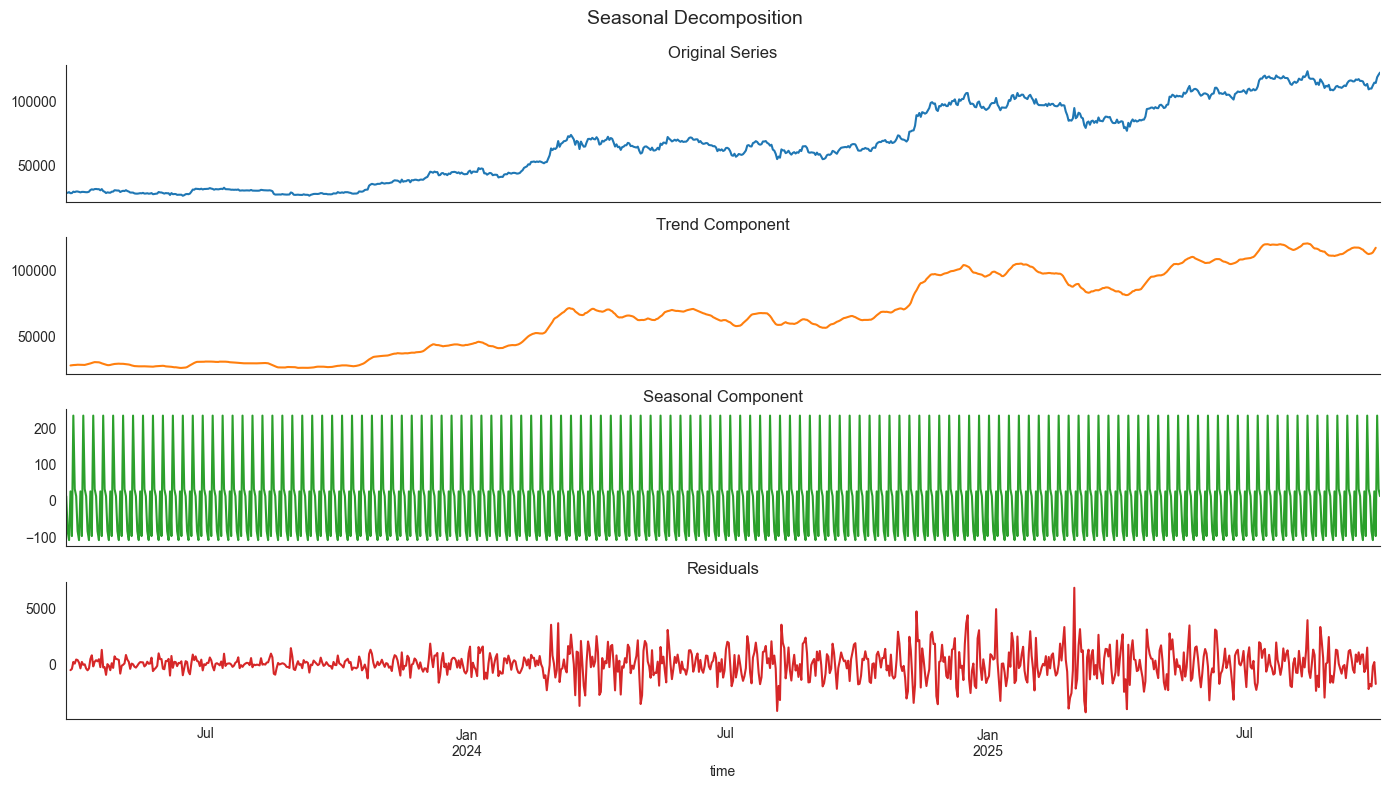

In [47]:
ts = (daily_btc.to_frame('Original')
      .assign(Trend=components.trend)
      .assign(Seasonality=components.seasonal)
      .assign(Residual=components.resid))
with sns.axes_style('white'):
    ts.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91)

## Time Series Stationarity

The statistical properties, such as the mean, variance, or autocorrelation, of a stationary time series are independent of the period, that is, they don't change over time. Hence, stationarity implies that a time series does not have a trend or seasonal effects and that descriptive statistics, such as the mean or the standard deviation, when computed for different rolling windows, are constant or do not change much over time. It reverts to its mean, and the deviations have constant amplitude, while short-term movements always look the same in the statistical sense.

More formally, strict stationarity requires the joint distribution of any subset of time series observations to be independent of time with respect to all moments. So, in addition to the mean and variance, higher moments such as skew and kurtosis, also need to be constant, irrespective of the lag between different observations. In most applications, we limit stationarity to first and second moments so that the time series is covariance stationary with constant mean, variance, and autocorrelation. 

Note that we specifically allow for dependence between observations at different lags, just like we want the input data for linear regression to be correlated with the outcome. Stationarity implies that these relationships are stable, which facilitates prediction as the model can focus on learning systematic patterns that take place within stable statistical properties. It is important because classical statistical models assume that the time series input data is stationary. 

To satisfy the stationarity assumption of linear time series models, we need to transform the original time series, often in several steps. Common transformations include the application of the (natural) logarithm to convert an exponential growth pattern into a linear trend and stabilize the variance. Deflation implies dividing a time series by another series that causes trending behavior, for example dividing a nominal series by a price index to convert it into a real measure.

### Log Transformation

Double check fo zero values

In [48]:
daily_btc_log = np.log(daily_btc)

### Differencing

In many cases, de-trending is not sufficient to make the series stationary. Instead, we need to transform the original data into a series of period-to-period and/or season-to-season differences. In other words, we use the result of subtracting neighboring data points or values at seasonal lags from each other. Note that when such differencing is applied to a log-transformed series, the results represent instantaneous growth rates or returns in a financial context. 

If a univariate series becomes stationary after differencing d times, it is said to be integrated of the order of d, or simply integrated if d=1. This behavior is due to so-called unit roots.

Differencing of log series produces instantaneous returns.

In [49]:
daily_btc_log_diff = daily_btc_log.diff().dropna()

### Plot Series

The following chart shows time series for the Bitcoin stock index for the 2.5 years, as well as the transformed versions after applying the logarithm and subsequently applying first and seasonal differences (at lag 12), respectively. The charts also display the ADF p-value, which allows us to reject the hypothesis of unit-root non-stationarity after all transformations in both cases:

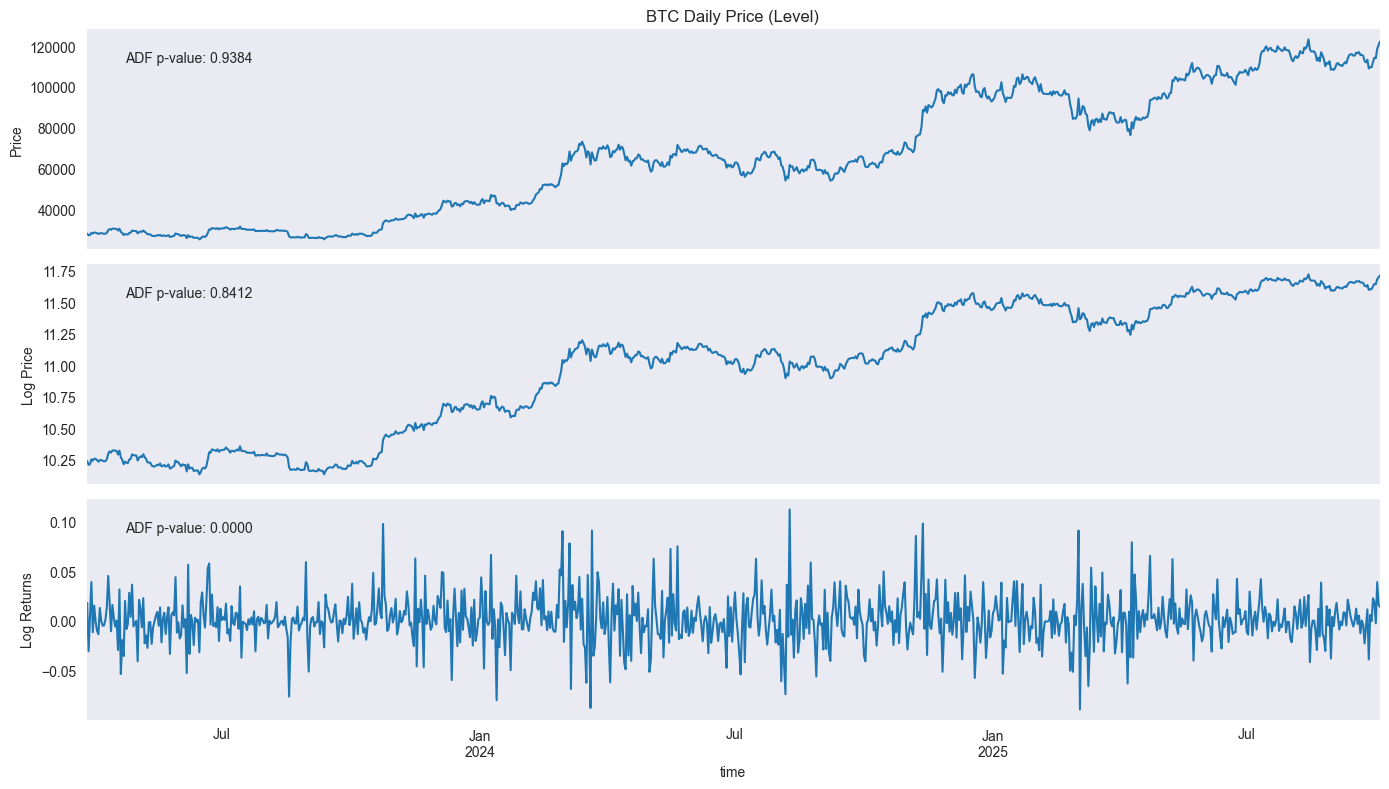

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa

with sns.axes_style('dark'):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 8), sharex=True)

    # --- Level ---
    daily_btc.plot(ax=axes[0], title='BTC Daily Price (Level)')
    axes[0].text(
        0.03, 0.85,
        f'ADF p-value: {tsa.adfuller(daily_btc.dropna())[1]:.4f}',
        transform=axes[0].transAxes
    )
    axes[0].set_ylabel('Price')

    # --- Log ---
    daily_btc_log.plot(ax=axes[1])
    axes[1].text(
        0.03, 0.85,
        f'ADF p-value: {tsa.adfuller(daily_btc_log.dropna())[1]:.4f}',
        transform=axes[1].transAxes
    )
    axes[1].set_ylabel('Log Price')

    # --- Log Diff ---
    daily_btc_log_diff.plot(ax=axes[2])
    axes[2].text(
        0.03, 0.85,
        f'ADF p-value: {tsa.adfuller(daily_btc_log_diff.dropna())[1]:.4f}',
        transform=axes[2].transAxes
    )
    axes[2].set_ylabel('Log Returns')

    sns.despine()
    fig.tight_layout()


## Correlogram

Autocorrelation (also called serial correlation) adapts the concept of correlation to the time series context: just as the correlation coefficient measures the strength of a linear relationship between two variables, the autocorrelation coefficient, $\rho_k$, measures the extent of a linear relationship between time series values separated by a given lag, $k$.

Hence, we can calculate one autocorrelation coefficient for each of the T-1 lags in a time series; T is the length of the series. The autocorrelation function (ACF) computes the correlation coefficients as a function of the lag.
The autocorrelation for a lag larger than 1 (that is, between observations more than one time step apart) reflects both the direct correlation between these observations and the indirect influence of the intervening data points. The partial autocorrelation removes this influence and only measures the linear dependence between data points at the given lag distance. The partial autocorrelation function (PACF) provides all the correlations that result once the effects of a correlation at shorter lags have been removed.

There are algorithms that estimate the partial autocorrelation from the sample autocorrelation based on the exact theoretical relationship between the PACF and the ACF.

A correlogram is simply a plot of the ACF or PACF for sequential lags, k=0,1,...,n. It allows us to inspect the correlation structure across lags at one glance. The main usage of correlograms is to detect any autocorrelation after the removal of the effects of deterministic trend or seasonality. Both the ACF and the PACF are key diagnostic tools for the design of linear time series models and we will review examples of ACF and PACF plots in the following section on time series transformations.

### NASDAQ (log, diff)

We can further analyze the relevant time series characteristics for the transformed series using a Q-Q plot that compares the quantiles of the distribution of the time series observation to the quantiles of the normal distribution and the correlograms based on the ACF and PACF.

For the NASDAQ plot, we notice that while there is no trend, the variance is not constant but rather shows clustered spikes around periods of market turmoil in the late 1980s, 2001, and 2008. The Q-Q plot highlights the fat tails of the distribution with extreme values more frequent than the normal distribution would suggest. The ACF and the PACF show similar patterns with autocorrelation at several lags appearing significant:

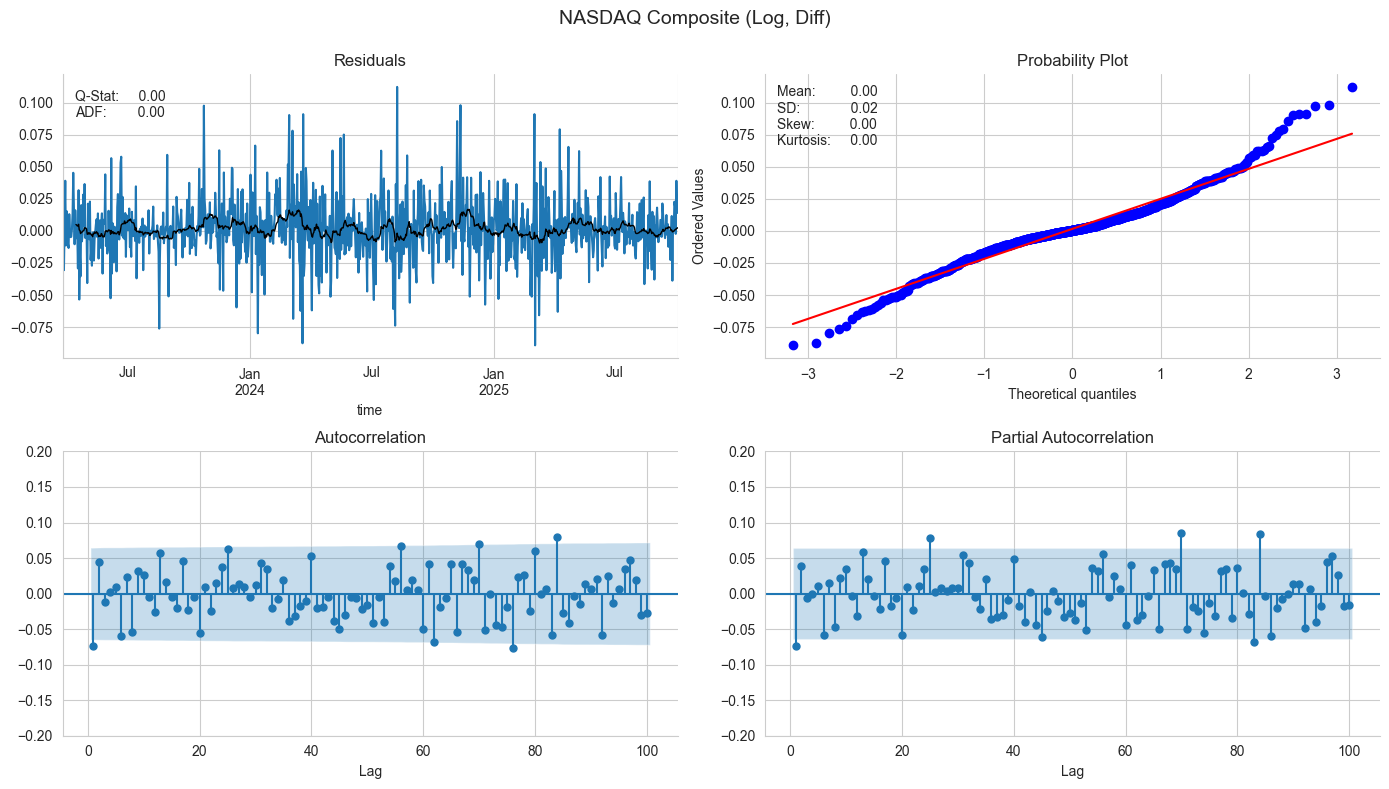

In [51]:
plot_correlogram(daily_btc_log_diff, lags=100, title='NASDAQ Composite (Log, Diff)', acf_ylim=(-0.2, 0.2), pacf_ylim=(-0.2, 0.2))